# Import libraries

In [1]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 13.9/13.9 MB 10.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\katap\.virtualenvs\workspace\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from langdetect import detect
import datetime
from nltk import word_tokenize
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import figure
import contractions
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models.fasttext import FastText
import fasttext
from sklearn.decomposition import PCA
import dask.dataframe as dd
import joblib
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import spreg

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\katap\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\katap\.virtualenvs\workspace\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


# Getting data

For this project I used a dataset in order to get the tweets I was interested in. For more details see:
https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329

In [ ]:
df = pd.read_csv('data/tweets.csv', delimiter=';')

In [ ]:
df.head()

In [5]:
# drop unused columns
df = df.drop(['id', 'fullname', 'url', 'user'], axis=1)
df.reset_index(drop=True, inplace=True)
df.head()

,timestamp,replies,likes,retweets,text
0,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [6]:
# Save raw tweets
pickle_out = open('data/tweets_raw.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Transform timestamp column in a date format

In [7]:
# Load raw tweets
pickle_in = open('data/tweets_raw.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [45]:
# Convert timestamp to date
def dt(x):
    t = pd.Timestamp(x)
    return pd.Timestamp.date(t)

In [9]:
df['timestamp'] = df['timestamp'].progress_apply(dt)

100%|██████████| 20165013/20165013 [00:53<00:00, 375805.34it/s]


# Filter tweets from December 1 2017 to February 1 2018

In [10]:
starDate = datetime.date(2018, 1, 1)
endDate = datetime.date(2018, 12, 31)

In [11]:
# Set start date of tweets
df = df[df['timestamp'] >= starDate]

In [12]:
# Set end date of tweets
df = df[df['timestamp'] <= endDate]

In [13]:
len(df["text"])

2164498

In [14]:
min(df['timestamp'])

datetime.date(2018, 1, 1)

In [15]:
max(df['timestamp'])

datetime.date(2018, 12, 31)

In [16]:
# Save tweets from December 1 2017 to February 1 2018
pickle_out = open('data/tweets_jan2018_dec2018.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Detect the language

In [17]:
# Load tweets from December 1 2017 to February 1 2018
pickle_in = open('data/tweets_jan2018_dec2018.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [18]:
# Check tweet language
# def detect_lang(text):
#     try:
#         lang = detect(text)
#     except:
#         lang = 'Other'
#     return lang

In [19]:
# df['language'] = df['text'].progress_apply(lambda x: detect_lang(x))

In [20]:
path_to_pretrained_model = 'data/fasttext_detect_lang_pretrain.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)

In [21]:
def detect_lang(text):
    return fmodel.predict(text)

In [22]:
df['text'] = df['text'].progress_apply(lambda x: str(x))

100%|██████████| 2164498/2164498 [00:01<00:00, 1923864.08it/s]


In [23]:
df['text'] = df['text'].progress_apply(lambda x: x.replace('\n', ' '))

100%|██████████| 2164498/2164498 [00:01<00:00, 1489432.89it/s]


In [24]:
df['language'] = df['text'].progress_apply(lambda x: detect_lang(x))

100%|██████████| 2164498/2164498 [00:43<00:00, 50204.92it/s] 


In [25]:
df['language'] = df['language'].progress_apply(lambda x: x[0][0].split('__')[2])

100%|██████████| 2164498/2164498 [00:01<00:00, 1610654.61it/s]


In [26]:
df['language'] = df['language'].progress_apply(lambda x: str(x))

100%|██████████| 2164498/2164498 [00:01<00:00, 2131033.44it/s]


In [27]:
df = df[df['language'] == 'en']

In [28]:
len(df["text"])

1248325

There are 1248325 tweets in english available for search terms #bitcoin or #BTC from January 1 2018 to December 31 2018.

In [29]:
# Save english tweets
pickle_out = open('data/tweets_en.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Create the Corpus

In [48]:
# Load raw tweets
pickle_in = open('data/tweets_en.pkl','rb')
df = pickle.load(pickle_in)
pickle_in.close()

In [49]:
# def text_cleaning(text):
#     # remove emoji
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                "]+", flags=re.UNICODE)
#     text = emoji_pattern.sub(r'', text)
#     forbidden_words = set(stopwords.words('english'))
#     text = ' '.join(text.split('.'))
#     text = re.sub('\/',' ',text)
#     text = text.strip('\'"')
#     text = re.sub(r'@([^\s]+)',r'\1',text)
#     text = re.sub(r'\\',' ',text)
#     text = text.lower()
#     text = re.sub('[\s]+', ' ', text)
#     text = re.sub(r'#([^\s]+)', r'\1', text)
#     text = re.sub('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ',text)
#     text = re.sub('(http.{1,100}\b)|(www.{1,100}\b)',' ',text)
#     text = re.sub(r'((http)\S+)','',text)
#     text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
#     text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
#     text = [word for word in text.split() if word not in forbidden_words]
#     return ' '.join(text)

In [50]:
# Clean the text
def clean_text(raw_string):
    # remove emoji
    # emoji_pattern = re.compile("["
    #                            u"\U0001F600-\U0001F64F"  # emoticons
    #                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #                            u"\U00002702-\U000027B0"
    #                            u"\U000024C2-\U0001F251"
    #                            "]+", flags=re.UNICODE)
    # cleaned_string = emoji_pattern.sub(r'', raw_string)

    cleaned_string = raw_string
    #remove handles
    cleaned_string = re.sub(r'@(\S+)', '', raw_string)

    cleaned_string = re.sub(r'\$(\S+)', '', raw_string)
    # remove urls
    cleaned_string = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', cleaned_string)
    # remove special characters
    # cleaned_string = re.sub("[^A-Za-zșȘȚțÎîÂâĂă.,:!?'\- ]", " ", cleaned_string, re.I)
    cleaned_string = re.sub(r'[^A-Za-z.,:!?\'’;\-# ]', " ", cleaned_string, re.I)
    # remove multiple spaces
    cleaned_string = re.sub(' +', ' ', cleaned_string)
    return cleaned_string

In [51]:
df['text']= df['text'].astype(str)

In [52]:
df.head(25)

,timestamp,replies,likes,retweets,text,language
101,2018-09-11,0.0,3.0,2.0,I didnt tether at $7300 #iamspartacus $btc $et...,en
416,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 1955 &a...,en
860,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en
1599,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en
4222,2018-06-09,39.0,324.0,160.0,Wow! We reached 25K followers just within 4 we...,en
4633,2018-05-05,32.0,197.0,183.0,I’m back!!! Today's #giveaway is 0.35 #BTC (va...,en
5912,2018-12-29,180.0,2059.0,648.0,Is #History repeating? 🤔 #Bitcoin / #Gold ht...,en
9926,2018-02-16,90.0,1598.0,502.0,Professional Certifications that will help jum...,en
13079,2018-08-07,85.0,95.0,87.0,I will choose 10 Random Followers to Win 1000 ...,en
13306,2018-12-29,2.0,100.0,132.0,"Remiit, a blockchain-powered remittance platfo...",en


In [53]:
tweet_corpus = pd.DataFrame(df)
tweet_corpus['text'] = tweet_corpus['text'].progress_apply(lambda text: clean_text(text))

100%|██████████| 1248325/1248325 [00:18<00:00, 66538.00it/s]


In [54]:
tweet_corpus.head(25)

,timestamp,replies,likes,retweets,text,language
101,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en
416,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en
860,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en
1599,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en
4222,2018-06-09,39.0,324.0,160.0,Wow! We reached K followers just within 4 week...,en
4633,2018-05-05,32.0,197.0,183.0,I’m back!!! Today's #giveaway is . 5 #BTC (val...,en
5912,2018-12-29,180.0,2059.0,648.0,Is #History repeating? #Bitcoin #Gold,en
9926,2018-02-16,90.0,1598.0,502.0,Professional Certifications that will help jum...,en
13079,2018-08-07,85.0,95.0,87.0,I will choose Random Followers to Win 1000 #AD...,en
13306,2018-12-29,2.0,100.0,132.0,"Remiit, a blockchain-powered remittance platfo...",en


In [55]:
# Save clean tweets
pickle_out = open('data/tweets_clean.pkl','wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

# Compute number of words in tweet

In [56]:
# Load english tweets
pickle_in = open('data/tweets_clean.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [57]:
tweet_corpus['text_len'] = tweet_corpus['text'].progress_apply(lambda x: len(word_tokenize(x)))

100%|██████████| 1248325/1248325 [01:54<00:00, 10882.89it/s]


In [58]:
tweet_corpus.sample(5)

,timestamp,replies,likes,retweets,text,language,text_len
4853106,2018-08-03,0.0,0.0,0.0,Bitcoin Post,en,2
2518921,2018-05-13,0.0,0.0,0.0,Current price of Bitcoin is Chain,en,6
2618625,2018-08-27,0.0,0.0,0.0,#CryptoMarkets top price update 1h -0.19% -0.3...,en,26
6604028,2018-04-05,0.0,0.0,0.0,RT LordOfDaCrypto RT CoolCousinCo: 4 HOURS ONL...,en,27
3765437,2018-02-06,0.0,0.0,0.0,I feel like I'll be the only person left holdi...,en,32


In [59]:
tweet_corpus.to_csv('data/tweet_corpus.csv', index=False)

In [49]:
tweet_corpus = pd.read_csv('data/tweet_corpus.csv')
tweet_corpus.head()

,timestamp,replies,likes,retweets,text,language,text_len
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59
2,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en,15
3,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en,62
4,2018-06-09,39.0,324.0,160.0,Wow! We reached K followers just within 4 week...,en,48


# Preprocess data

In [50]:
# Check data types in corpus
tweet_corpus.dtypes

timestamp     object
replies      float64
likes        float64
retweets     float64
text          object
language      object
text_len       int64
dtype: object

In [51]:
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text          True
language     False
text_len     False
dtype: bool

In [52]:
tweet_corpus = tweet_corpus.dropna()

In [53]:
# Transform data types to strings for easy management
tweet_corpus['text'] = tweet_corpus['text'].astype(str)

In [54]:
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text         False
language     False
text_len     False
dtype: bool

In [55]:
replies_number = tweet_corpus['replies'].value_counts().sort_index()
replies_number = replies_number.drop(index = replies_number.index[0], axis = 0)

In [56]:
replies_number

1.0        69102
2.0        16960
3.0         6945
4.0         3436
5.0         2032
           ...  
4953.0         1
5158.0         1
5215.0         1
7349.0         1
22759.0        1
Name: replies, Length: 515, dtype: int64

In [57]:
# Plot the frequency of number of replies
figure(num=None, figsize=(20,18), dpi=512, facecolor='w', edgecolor='r')
# fig = tweet_corpus['replies'].value_counts().sort_index().plot(kind='bar')
fig = replies_number.plot(kind='bar')
fig.set_title('Replies number frequency')
fig.set_xlabel('Number of replies')
fig.set_ylabel('Frequency')
plt.show()

In [58]:
# Plot the frequency of number of words in tweets
figure(num=None, figsize=(20,18), dpi=512, facecolor='w', edgecolor='r')
fig = tweet_corpus['text_len'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of number of words in tweets')
fig.set_xlabel('Number of words in tweets')
fig.set_ylabel('Frequency')
plt.show()

In [59]:
def preprocess(document):
    document = str(document)
    # Contractions
    #document = contractions.fix(document)
    # Lowercasing
    #document = document.lower()
    # Remove any whitespaces
    #document = re.sub(r'[^\w\s]', ' ', document)
    #document = re.sub(r'[^a-z ]', '', document)
    # Word Tokenize
    document = word_tokenize(document)
    # Stopwords
    stop_words = stopwords.words('english')
    document = [word for word in document if word not in stop_words]
    # Lemmatizer
    document = ' '.join(document)
    document = [word.lemma_ for word in nlp(document)]
    # Change the output to a sentence
    document = ' '.join(document)

    return document

In [60]:
tweet_corpus['text'][48679]

'Bitcoin - BTC Price: Change in h: - .21% Market cap: Ranking: 1 #Bitcoin #BTC'

In [61]:
tweet_corpus['text_prep'] = tweet_corpus['text'].progress_apply(lambda x: preprocess(x))

100%|██████████| 1247832/1247832 [39:44<00:00, 523.38it/s]


In [62]:
#tweet_corpus['text_prep'] = [preprocess(document) for document in tweet_corpus['text'].to_list()]
tweet_corpus.head(2)

,timestamp,replies,likes,retweets,text,language,text_len,text_prep
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...


In [63]:
# Save corpus in csv
tweet_corpus.to_csv('data/tweet_corpus_clean.csv', index=False)

# Bag of words top 5000

In [2]:
# Read corpus from csv
tweet_corpus = pd.read_csv('data/tweet_corpus_clean.csv')

In [3]:
# Check for missing values
tweet_corpus.isna().any()

timestamp    False
replies      False
likes        False
retweets     False
text         False
language     False
text_len     False
text_prep     True
dtype: bool

In [4]:
# Remove missing values
tweet_corpus = tweet_corpus.dropna()

In [5]:
corpus_text = tweet_corpus['text_prep']

In [6]:
# Create dtm (document term matrix) for most frequent 5000 words
vec_text = CountVectorizer(max_features=4000)
counts_per_text = vec_text.fit_transform(corpus_text)
counts_per_text

<1247006x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 11576089 stored elements in Compressed Sparse Row format>

In [7]:
text_words = vec_text.get_feature_names_out()
text_words[np.random.randint(0, len(text_words) - 1)]

'centralize'

In [8]:
# dtm_text_dd = dd.from_array(counts_per_text.toarray(), columns = text_words)
# dtm_text_dd.head()

In [9]:
dtm_text = pd.DataFrame(counts_per_text.toarray(), columns = text_words)
dtm_text.head(5)

,00,000,0000,00000,000000,00000000,00000001,00000002,00000003,00000019,...,zen,zencash,zeos,zero,zerocarbonproject,zil,zilliqa,zone,zrx,ás
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Create new column that contains only the words in DTM (from the 5000 words)
tweet_corpus['text_prep_lim'] = tweet_corpus['text_prep'].progress_apply(word_tokenize)
tweet_corpus.head(2)

100%|██████████| 1247006/1247006 [02:06<00:00, 9868.67it/s] 


,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[I, do, not, tether, #, iamspartacus]"
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, lab, make, diamond, happen, 55, &..."


In [11]:
# Check in the 5000 words and see if text_prep words are in there
tweet_corpus['text_prep_lim'] = tweet_corpus['text_prep_lim'].progress_apply(lambda x:[word for word in x if word in text_words])
tweet_corpus.head(2)

100%|██████████| 1247006/1247006 [17:35<00:00, 1181.93it/s]


,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[do, not, tether]"
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, make, diamond, happen, 55, amp, m..."


In [12]:
# Get no of words
tweet_corpus['word_len_text_lim'] = tweet_corpus['text_prep_lim'].progress_apply(len)
tweet_corpus.head(2)

100%|██████████| 1247006/1247006 [00:00<00:00, 1734811.22it/s]


,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim,word_len_text_lim
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[do, not, tether]",3
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, make, diamond, happen, 55, amp, m...",26


In [14]:
# Save the dtms
# dtm_text.to_csv("data/dtm_text_bow.csv", index=False)
# tweet_corpus.to_csv('data/tweet_corpus_cleaned.csv', index=False)

In [23]:
# Save clean tweets
# pickle_out = open('data/dtm_text_bow.pkl','wb')
# pickle.dump(dtm_text, pickle_out)
# pickle_out.close()

MemoryError: 

In [15]:
# Save clean tweets
pickle_out = open('data/tweet_corpus_cleaned.pkl','wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

In [25]:
import joblib

In [26]:
filename = 'dtm_text_bow.sav'
joblib.dump(dtm_text, filename)

['dtm_text_bow.sav']

# Wordcloud

In [56]:
# Load english tweets
# pickle_in = open('data/dtm_text_bow.pkl','rb')
# dtm_text = pickle.load(pickle_in)
# pickle_in.close()

In [2]:
filename = 'dtm_text_bow.sav'
dtm_text = joblib.load(filename)

In [3]:
# Load english tweets
pickle_in = open('data/tweet_corpus_cleaned.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [4]:
# Read the dtms
#dtm_text = pd.read_csv('data/dtm_text_bow.csv', engine='python')

In [ ]:
tweet_corpus = pd.read_csv('data/tweet_corpus_cleaned.csv')

In [5]:
dtm_text.head()

,00,000,0000,00000,000000,00000000,00000001,00000002,00000003,00000019,...,zen,zencash,zeos,zero,zerocarbonproject,zil,zilliqa,zone,zrx,ás
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
wordcloud_freq_text = dtm_text.sum(axis=0)
wordcloud_freq_text

00         267745
000         22770
0000          647
00000        5002
000000        910
            ...  
zil           341
zilliqa       312
zone         1381
zrx           455
ás           3120
Length: 4000, dtype: int64

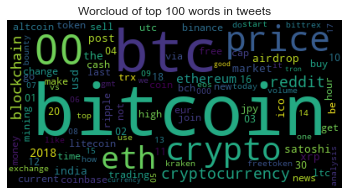

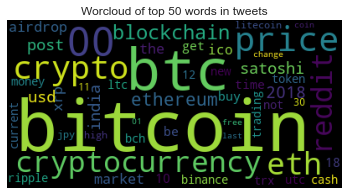

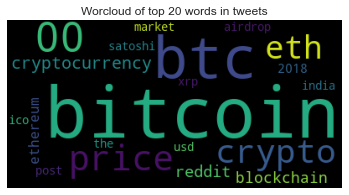

In [7]:
for i in [100,50,20]:
    wordcloud_text = WordCloud(max_words=i, background_color = 'black', colormap = None)
    wordcloud_text.generate_from_frequencies(wordcloud_freq_text)
    plt.imshow(wordcloud_text)
    plt.axis('off')
    plt.title(f"Worcloud of top {i} words in tweets")
    plt.show()

# Word Frequency

In [8]:
word_freq_text = pd.DataFrame(wordcloud_freq_text).reset_index()
word_freq_text.columns = ['Word', 'Count']
word_freq_text.head()

,Word,Count
0,00,267745
1,000,22770
2,0000,647
3,00000,5002
4,000000,910


In [9]:
# Let's check the most frequent words
word_freq_text = word_freq_text.sort_values(by='Count', ascending=False)

In [10]:
# Let's create a barchart of frequencies
top20_text = word_freq_text[0:19].copy()
top20_text

,Word,Count
1147,bitcoin,948213
1264,btc,610471
0,00,267745
3018,price,183882
1549,crypto,166486
1843,eth,153108
1558,cryptocurrency,139937
3133,reddit,132836
1201,blockchain,123092
1845,ethereum,95353


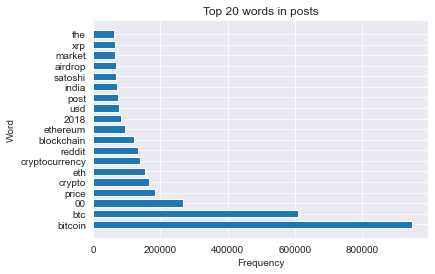

In [11]:
plt.barh(y=top20_text['Word'],width=top20_text['Count'], height = 0.7)
plt.title("Top 20 words in posts")
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [12]:
final_list = []
for word in top20_text["Word"]:
    final_list.append(word)

In [13]:
pickle_out = open('data/final_list_top20_words.pkl','wb')
pickle.dump(final_list, pickle_out)
pickle_out.close()

# Text Representation using FastText

In [14]:
# Create corpus vectors from the top 5000 words in the comments and posts
corpus_text = tweet_corpus['text_prep_lim']

In [15]:
final_size = 60
window_size = 10
min_word = 3
corpus_text

0                                          [do, not, tether]
1          [the, first, make, diamond, happen, 55, amp, m...
2                           [great, talk, discussion, thank]
3          [when, thing, remember, be, never, bad, crash,...
4          [wow, we, reach, follower, within, week, we, h...
                                 ...                        
1247827                                         [investment]
1247828    [why, not, invest, future, option, do, want, m...
1247829    [think, share, wave, count, least, happen, see...
1247830    [welcome, here, be, who, trust, nobody, when, ...
1247831    [really, come, actual, reddit, thread, be, sta...
Name: text_prep_lim, Length: 1247006, dtype: object

In [16]:
# Create the fast text models for both vectors

model_text = FastText(vector_size=final_size,
                       window=window_size,
                       min_count=min_word,
                       seed=1,
                       workers=1)
model_text.build_vocab(corpus_iterable = corpus_text)
model_text.train(corpus_iterable=corpus_text, total_examples=len(corpus_text), epochs=50)

(291774718, 357115350)

In [17]:
# 60-dimensional vector for the word "bitcoin"
model_text.wv['bitcoin']

array([ 1.6009356 , -0.28262973, -0.6822824 ,  0.17728767,  0.6899079 ,
       -0.19187637,  1.1600463 ,  1.2643577 ,  0.03548566, -1.3402694 ,
       -0.04970152,  2.624476  , -1.4462234 ,  1.8827282 ,  1.2718114 ,
       -0.3885834 , -1.8320727 , -1.601359  , -2.2910683 ,  0.0459244 ,
       -1.2181262 , -2.1971924 ,  0.3010652 ,  3.1407838 ,  0.5883924 ,
       -1.7108014 , -0.35718367,  0.8825571 ,  0.17838424, -1.8243912 ,
       -1.2272103 , -0.88260883, -0.47484332,  1.1481907 ,  0.8160737 ,
       -1.7777793 ,  1.9489262 ,  2.0623848 , -0.7121675 ,  0.18485568,
        0.48917174, -0.6485496 ,  0.19871774,  3.1282628 ,  0.11026921,
       -0.0602221 , -2.1443422 ,  0.0260402 , -0.20028655,  2.8262954 ,
        1.8353908 , -1.5603502 , -0.7670935 ,  0.27361852, -0.9281388 ,
        1.7366959 ,  0.82821333,  3.2666306 ,  0.51051974, -0.056998  ],
      dtype=float32)

In [18]:
model_text.wv.most_similar('bitcoin', topn=5)

[('cryptocurrencynews', 0.7631758451461792),
 ('cryptocurrency', 0.7550831437110901),
 ('cryptocurrencynew', 0.7432304620742798),
 ('digitalcurrency', 0.7386982440948486),
 ('crypto', 0.7163277864456177)]

In [19]:
model_text.wv.similarity(w1='bitcoin', w2='crypto')

0.7163279

In [20]:
pickle_out = open('data/fast_text_model_text.pkl','wb')
pickle.dump(model_text, pickle_out)
pickle_out.close()

In [25]:
# Load english tweets
pickle_in = open('data/fast_text_model_text.pkl','rb')
model_text = pickle.load(pickle_in)
pickle_in.close()

In [26]:
# Visualize the model
X_text = model_text.wv[final_list]
X_text #an array with all 60-D vectors for all the words in final_list

array([[  1.6009356 ,  -0.28262973,  -0.6822824 , ...,   3.2666306 ,
          0.51051974,  -0.056998  ],
       [ -0.9929007 ,  -3.3606107 ,  -2.27609   , ...,   6.1103005 ,
          3.3786283 ,  -0.94326097],
       [  2.6808183 ,  -4.25941   ,   7.260543  , ...,  -3.402617  ,
          1.5637182 ,  -2.8334842 ],
       ...,
       [  2.6741009 ,  -4.069988  ,  -0.08360399, ...,   2.5238793 ,
          4.468277  ,  -0.3604773 ],
       [-13.810013  , -24.71207   ,  -0.517632  , ...,  18.992283  ,
         20.956823  ,   2.0740921 ],
       [  1.9034116 ,   0.60596055,  -1.3697745 , ...,  -4.100674  ,
         -6.413935  ,  -1.5037991 ]], dtype=float32)

# Principal component analysis (PCA)

In [27]:
# To plot sth nice let's reduce the 60 dimensions to 2
pca_text = PCA(n_components=2).fit_transform(X_text)
pca_text

array([[ -2.3787014 ,  -5.079511  ],
       [  3.8463066 ,  -4.7705665 ],
       [ -9.72626   ,  34.77736   ],
       [ -8.148636  ,   1.183112  ],
       [  0.9467757 ,  -7.727198  ],
       [  6.011486  , -10.386654  ],
       [ -1.2896094 ,  -6.23142   ],
       [ -3.5357099 ,   2.011647  ],
       [ -3.5089524 ,  -7.421863  ],
       [  3.6778178 ,  -7.7917542 ],
       [ -9.532382  ,  -1.0916312 ],
       [ -4.8641148 ,  -2.5107684 ],
       [ -9.019019  ,   9.807507  ],
       [ -4.8697367 ,  -5.686539  ],
       [ -5.5815506 ,   1.1220282 ],
       [  4.391305  ,   5.84426   ],
       [ -6.0183673 ,  -2.1162245 ],
       [ 65.300674  ,   6.5046706 ],
       [-15.701324  ,  -0.43646002]], dtype=float32)

In [28]:
fig = px.scatter(x = pca_text[:,0], y = pca_text[:,1], text = final_list)
fig.update_traces(textposition='top center', textfont_size=14)
fig.show()

# Sentiment analysis using Vader Lexicon

In [2]:
# Load english tweets
pickle_in = open('data/tweet_corpus_cleaned.pkl','rb')
tweet_corpus = pickle.load(pickle_in)
pickle_in.close()

In [3]:
# tweet_corpus = pd.read_csv('data/tweet_corpus_cleaned.csv')

In [4]:
tweet_corpus.head()

,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim,word_len_text_lim
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[do, not, tether]",3
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, make, diamond, happen, 55, amp, m...",26
2,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en,15,great talk discussion Bitcoin vs. Euro Innsbru...,"[great, talk, discussion, thank]",4
3,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en,62,"when thing , remember be never bad chocolate c...","[when, thing, remember, be, never, bad, crash,...",17
4,2018-06-09,39.0,324.0,160.0,Wow! We reached K followers just within 4 week...,en,48,wow ! we reach K follower within 4 week Twitte...,"[wow, we, reach, follower, within, week, we, h...",21


In [5]:
tweet_corpus['vader_score'] = tweet_corpus['text_prep'].progress_apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

100%|██████████| 1247006/1247006 [1:22:10<00:00, 252.89it/s]


In [7]:
text_vader_score = tweet_corpus['text'].progress_apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

100%|██████████| 1247006/1247006 [1:22:34<00:00, 251.71it/s]


In [8]:
text_prep_vader_score = tweet_corpus['vader_score']

In [18]:
backup = tweet_corpus

In [19]:
tweet_corpus = tweet_corpus.rename(columns={'vader_score': 'vader_score_prep'})

In [20]:
tweet_corpus['vader_score'] = text_vader_score

In [21]:
tweet_corpus.head()

,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim,word_len_text_lim,vader_score_prep,vader_score
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[do, not, tether]",3,0.0000,0.0000
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, make, diamond, happen, 55, amp, m...",26,0.7964,0.7678
2,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en,15,great talk discussion Bitcoin vs. Euro Innsbru...,"[great, talk, discussion, thank]",4,0.8011,0.8011
3,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en,62,"when thing , remember be never bad chocolate c...","[when, thing, remember, be, never, bad, crash,...",17,0.6259,0.0387
4,2018-06-09,39.0,324.0,160.0,Wow! We reached K followers just within 4 week...,en,48,wow ! we reach K follower within 4 week Twitte...,"[wow, we, reach, follower, within, week, we, h...",21,0.9333,0.9368


In [22]:
tweet_corpus.describe()

,replies,likes,retweets,text_len,word_len_text_lim,vader_score_prep,vader_score
count,1.247006e+06,1.247006e+06,1.247006e+06,1.247006e+06,1.247006e+06,1.247006e+06,1.247006e+06
mean,6.020885e-01,4.480204e+00,1.789222e+00,1.943342e+01,5.727564e+00,8.563610e-02,8.067019e-02
std,3.089878e+01,3.076061e+02,8.776422e+01,1.704734e+01,5.544436e+00,2.990732e-01,2.931557e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-9.970000e-01,-9.948000e-01
25%,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,4.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01,8.000000e+00,7.720000e-02,0.000000e+00
max,2.275900e+04,2.829590e+05,6.401300e+04,1.790000e+02,4.600000e+01,9.919000e-01,9.928000e-01


In [27]:
vader_class = []
for score in tweet_corpus['vader_score']:
    if 1 > score > 0.05:
        vader_class.append('positive')
    elif -0.05 > score > -1:
        vader_class.append('negative')
    else:
        vader_class.append('neutral')

vader_class

['neutral',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'posit

In [28]:
tweet_corpus['vader_class'] = vader_class

In [29]:
vader_class_prep = []
for score in tweet_corpus['vader_score_prep']:
    if 1 > score > 0.05:
        vader_class_prep.append('positive')
    elif -0.05 > score > -1:
        vader_class_prep.append('negative')
    else:
        vader_class_prep.append('neutral')

vader_class_prep

['neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 '

In [30]:
tweet_corpus['vader_class_prep'] = vader_class_prep

In [31]:
tweet_corpus.head()

,timestamp,replies,likes,retweets,text,language,text_len,text_prep,text_prep_lim,word_len_text_lim,vader_score_prep,vader_score,vader_class,vader_class_prep
0,2018-09-11,0.0,3.0,2.0,I didnt tether at #iamspartacus,en,6,I do not tether # iamspartacus,"[do, not, tether]",3,0.0000,0.0000,neutral,neutral
1,2018-12-29,9.0,61.0,16.0,The first lab made diamond happened in 55 &amp...,en,59,the first lab make diamond happen 55 & amp ; f...,"[the, first, make, diamond, happen, 55, amp, m...",26,0.7964,0.7678,positive,positive
2,2018-04-17,1.0,7.0,1.0,Great talk and discussions about Bitcoin vs. E...,en,15,great talk discussion Bitcoin vs. Euro Innsbru...,"[great, talk, discussion, thank]",4,0.8011,0.8011,positive,positive
3,2018-02-08,23.0,135.0,51.0,"When things are down, remember it's never as b...",en,62,"when thing , remember be never bad chocolate c...","[when, thing, remember, be, never, bad, crash,...",17,0.6259,0.0387,neutral,positive
4,2018-06-09,39.0,324.0,160.0,Wow! We reached K followers just within 4 week...,en,48,wow ! we reach K follower within 4 week Twitte...,"[wow, we, reach, follower, within, week, we, h...",21,0.9333,0.9368,positive,positive


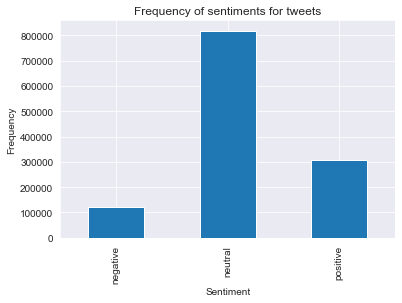

In [109]:
fig = tweet_corpus['vader_class'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of sentiments for tweets')
fig.set_xlabel('Sentiment')
fig.set_ylabel('Frequency')
plt.show()

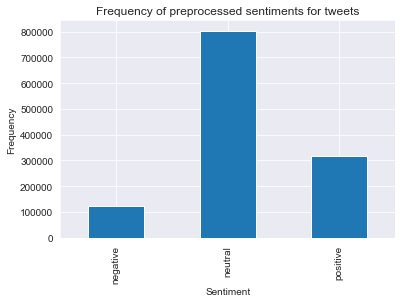

In [110]:
fig = tweet_corpus['vader_class_prep'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of preprocessed sentiments for tweets')
fig.set_xlabel('Sentiment')
fig.set_ylabel('Frequency')
plt.show()

In [32]:
pickle_out = open('data/tweets_vader.pkl', 'wb')
pickle.dump(tweet_corpus, pickle_out)
pickle_out.close()

In [33]:
tweet_corpus.to_csv("data/tweets_vader.csv", index=False)

# Read bitcoin price dataset

In [34]:
bitcoin_price = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [35]:
bitcoin_price.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
bitcoin_price = bitcoin_price.dropna()

In [37]:
bitcoin_price.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [38]:
def ttd(x):
    return datetime.datetime.utcfromtimestamp(x)

In [39]:
bitcoin_price['Timestamp'] = bitcoin_price['Timestamp'].progress_apply(ttd)

100%|██████████| 3613769/3613769 [00:02<00:00, 1432882.88it/s]


In [40]:
bitcoin_price.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [41]:
bitcoin_price.isna().any()

Timestamp            False
Open                 False
High                 False
Low                  False
Close                False
Volume_(BTC)         False
Volume_(Currency)    False
Weighted_Price       False
dtype: bool

In [42]:
min(bitcoin_price['Timestamp'])

Timestamp('2011-12-31 07:52:00')

In [43]:
max(bitcoin_price['Timestamp'])

Timestamp('2021-03-31 00:00:00')

In [46]:
bitcoin_price['date'] = bitcoin_price['Timestamp'].progress_apply(dt)

100%|██████████| 3613769/3613769 [00:07<00:00, 509825.59it/s] 


In [47]:
bitcoin_price.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [48]:
starDate = datetime.date(2018, 1, 1)
endDate = datetime.date(2018, 12, 31)

In [49]:
bitcoin_price = bitcoin_price[bitcoin_price['date'] >= starDate]

In [50]:
bitcoin_price = bitcoin_price[bitcoin_price['date'] <= endDate]

In [51]:
bitcoin_price.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
3150976,2018-01-01 00:00:00,13880.00,13906.37,13841.00,13841.01,4.967997,69030.718890,13895.081610,2018-01-01
3150977,2018-01-01 00:01:00,13841.01,13890.43,13841.01,13890.43,1.665850,23064.082359,13845.237237,2018-01-01
3150978,2018-01-01 00:02:00,13846.64,13890.35,13846.64,13847.51,0.269346,3739.690844,13884.349123,2018-01-01
3150979,2018-01-01 00:03:00,13847.51,13874.92,13823.19,13823.19,1.155274,15986.279494,13837.650132,2018-01-01
3150980,2018-01-01 00:04:00,13823.19,13826.75,13803.20,13803.20,0.646691,8930.465767,13809.482390,2018-01-01


In [52]:
len(bitcoin_price)

505773

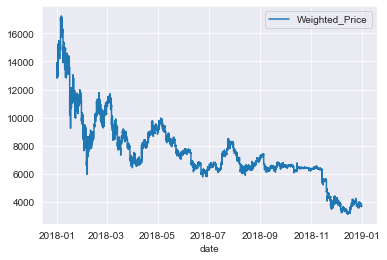

In [53]:
bitcoin_price.plot(x='date', y='Weighted_Price', kind="line")
plt.show()

In [54]:
bitcoin_price_avg = bitcoin_price.groupby('date').mean()

In [55]:
bitcoin_price_avg = bitcoin_price_avg.reset_index()

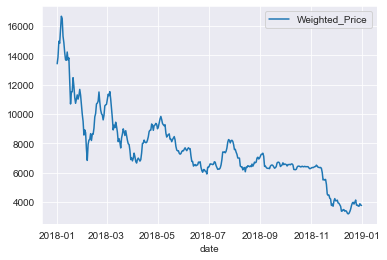

In [56]:
bitcoin_price_avg.plot(x='date', y='Weighted_Price', kind="line")
plt.show()

In [57]:
bitcoin_price.dtypes

Timestamp            datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
date                         object
dtype: object

In [58]:
bitcoin_price['date'] = pd.to_datetime(bitcoin_price['date'])

In [59]:
bitcoin_price_avg.dtypes

date                  object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [60]:
bitcoin_price_avg['date'] = pd.to_datetime(bitcoin_price_avg['date'])

In [63]:
tweet_corpus.dtypes

timestamp                    object
replies                     float64
likes                       float64
retweets                    float64
text                         object
language                     object
text_len                      int64
text_prep                    object
text_prep_lim                object
word_len_text_lim             int64
vader_score_prep            float64
vader_score                 float64
vader_class                  object
vader_class_prep             object
date                 datetime64[ns]
dtype: object

In [62]:
tweet_corpus['date'] = pd.to_datetime(tweet_corpus['timestamp'])

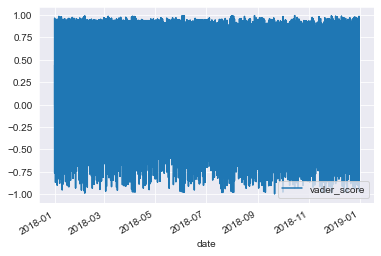

In [64]:
tweet_corpus.plot(x='date', y='vader_score', kind="line")
plt.show()

In [65]:
tweet_corpus_avg = tweet_corpus.groupby('date').mean()

In [66]:
tweet_corpus_avg = tweet_corpus_avg.reset_index()

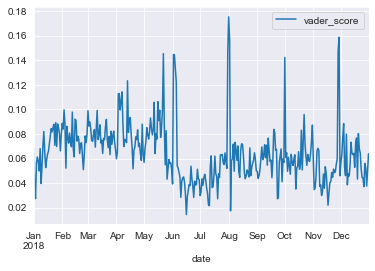

In [67]:
tweet_corpus_avg.plot(x='date', y='vader_score', kind="line")
plt.show()

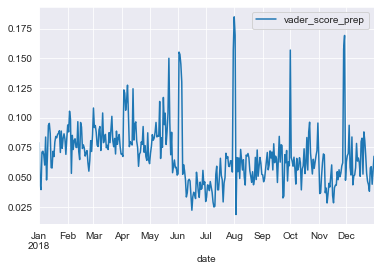

In [68]:
tweet_corpus_avg.plot(x='date', y='vader_score_prep', kind="line")
plt.show()

In [69]:
tweet_corpus.to_csv("data/tweets_corpus_vader.csv", index=False)

In [70]:
tweet_corpus_avg.to_csv("data/tweets_corpus_vader_avg.csv", index=False)

In [71]:
bitcoin_price.to_csv("data/bitcoin_price.csv", index=False)

In [72]:
bitcoin_price_avg.to_csv("data/bitcoin_price_avg.csv", index=False)

# Merge the dataframes

In [73]:
# tweet_corpus = pd.read_csv('data/tweets_corpus_vader.csv')
tweet_corpus_avg = pd.read_csv('data/tweets_corpus_vader_avg.csv')
# bitcoin_price = pd.read_csv('data/bitcoin_price.csv')
bitcoin_price_avg = pd.read_csv('data/bitcoin_price_avg.csv')

In [74]:
twitter_vaderAVG_priceAVG = pd.merge(tweet_corpus_avg, bitcoin_price_avg, on='date')

In [76]:

twitter_vaderAVG_priceAVG.to_csv('data/twitter_vaderAVG_priceAVG.csv', index=False)

In [3]:
twitter_vaderAVG_priceAVG = pd.read_csv('data/twitter_vaderAVG_priceAVG.csv')

In [4]:
twitter_vaderAVG_priceAVG.head()

,date,replies,likes,retweets,text_len,word_len_text_lim,vader_score_prep,vader_score,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2018-01-01,0.252503,1.743048,1.363737,26.778643,5.146830,0.078898,0.068968,13424.547451,13443.656127,13402.674599,13423.998655,5.414106,72405.435529,13422.567010
1,2018-01-02,0.877381,8.283333,10.578571,27.945238,5.691667,0.042676,0.039405,13876.355194,13898.509590,13855.027465,13879.358896,11.319215,159124.197276,13877.579911
2,2018-01-03,0.592822,11.955446,7.022277,27.592822,5.263614,0.039440,0.027376,14962.191285,14984.432583,14939.789938,14963.699340,8.524306,127527.370651,14962.379078
3,2018-01-04,0.729529,7.538462,3.107940,27.571960,5.468983,0.070949,0.056791,14816.667590,14839.287014,14793.340396,14818.780319,10.419457,154277.947563,14816.625468
4,2018-01-05,1.618026,7.723176,4.600858,26.424893,5.297210,0.071774,0.061243,15790.230722,15811.529299,15768.255285,15792.452507,11.283969,180344.370037,15790.446145


In [5]:
twitter_vaderAVG_priceAVG = twitter_vaderAVG_priceAVG.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'replies', 'likes', 'retweets', 'text_len', 'word_len_text_lim'])

In [6]:
twitter_vaderAVG_priceAVG

,date,vader_score_prep,vader_score,Weighted_Price
0,2018-01-01,0.078898,0.068968,13422.567010
1,2018-01-02,0.042676,0.039405,13877.579911
2,2018-01-03,0.039440,0.027376,14962.379078
3,2018-01-04,0.070949,0.056791,14816.625468
4,2018-01-05,0.071774,0.061243,15790.446145
...,...,...,...,...
360,2018-12-27,0.057753,0.056008,3717.518933
361,2018-12-28,0.058766,0.052362,3701.742855
362,2018-12-29,0.043943,0.037652,3873.097678
363,2018-12-30,0.055277,0.049953,3787.887224


In [7]:
twitter_vaderAVG_priceAVG.dtypes

date                 object
vader_score_prep    float64
vader_score         float64
Weighted_Price      float64
dtype: object

In [8]:
twitter_vaderAVG_priceAVG['date'] = pd.to_datetime(twitter_vaderAVG_priceAVG['date'])

In [9]:
twitter_vaderAVG_priceAVG['fluctuation (%)'] = twitter_vaderAVG_priceAVG['Weighted_Price'].pct_change()*100

In [10]:
twitter_vaderAVG_priceAVG

,date,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
0,2018-01-01,0.078898,0.068968,13422.567010,NaN
1,2018-01-02,0.042676,0.039405,13877.579911,3.389910
2,2018-01-03,0.039440,0.027376,14962.379078,7.816919
3,2018-01-04,0.070949,0.056791,14816.625468,-0.974134
4,2018-01-05,0.071774,0.061243,15790.446145,6.572486
...,...,...,...,...,...
360,2018-12-27,0.057753,0.056008,3717.518933,-1.624099
361,2018-12-28,0.058766,0.052362,3701.742855,-0.424371
362,2018-12-29,0.043943,0.037652,3873.097678,4.629031
363,2018-12-30,0.055277,0.049953,3787.887224,-2.200059


In [11]:
twitter_vaderAVG_priceAVG.corr()

,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
vader_score_prep,1.000000,0.983124,0.242265,0.051586
vader_score,0.983124,1.000000,0.214846,0.060072
Weighted_Price,0.242265,0.214846,1.000000,0.064805
fluctuation (%),0.051586,0.060072,0.064805,1.000000


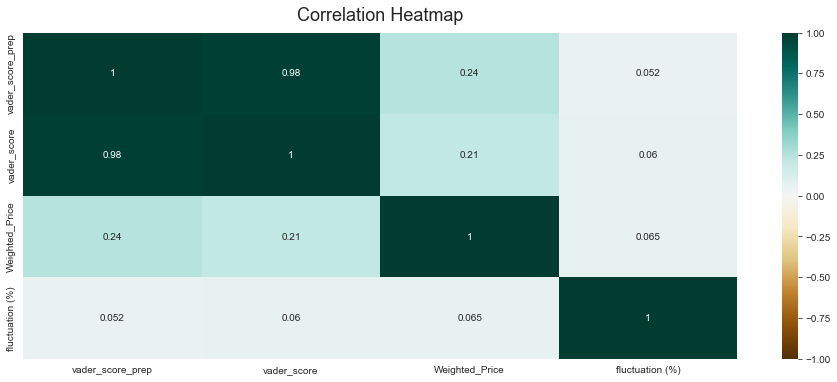

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(twitter_vaderAVG_priceAVG.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [13]:
lagged_correlation = pd.DataFrame.from_dict(
    {x: [twitter_vaderAVG_priceAVG['vader_score'].corr(twitter_vaderAVG_priceAVG['fluctuation (%)'].shift(-t)) for t in range(20)] for x in twitter_vaderAVG_priceAVG.columns})

In [14]:
lagged_correlation

,date,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
0,0.060072,0.060072,0.060072,0.060072,0.060072
1,0.019803,0.019803,0.019803,0.019803,0.019803
2,-0.046152,-0.046152,-0.046152,-0.046152,-0.046152
3,-0.036781,-0.036781,-0.036781,-0.036781,-0.036781
4,-0.034351,-0.034351,-0.034351,-0.034351,-0.034351
5,0.006527,0.006527,0.006527,0.006527,0.006527
6,-0.022397,-0.022397,-0.022397,-0.022397,-0.022397
7,-0.039846,-0.039846,-0.039846,-0.039846,-0.039846
8,-0.074839,-0.074839,-0.074839,-0.074839,-0.074839
9,-0.039031,-0.039031,-0.039031,-0.039031,-0.039031


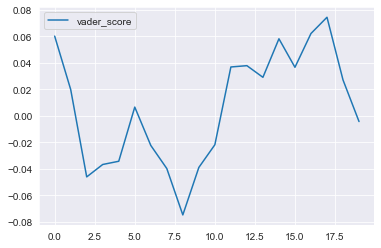

In [15]:
lagged_correlation.plot(y='vader_score', kind="line", use_index=True)
plt.show()

In [16]:
lagged_correlation_prep = pd.DataFrame.from_dict(
    {x: [twitter_vaderAVG_priceAVG['vader_score_prep'].corr(twitter_vaderAVG_priceAVG['fluctuation (%)'].shift(-t)) for t in range(20)] for x in twitter_vaderAVG_priceAVG.columns})

In [17]:
lagged_correlation_prep

,date,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
0,0.051586,0.051586,0.051586,0.051586,0.051586
1,0.007180,0.007180,0.007180,0.007180,0.007180
2,-0.042530,-0.042530,-0.042530,-0.042530,-0.042530
3,-0.037269,-0.037269,-0.037269,-0.037269,-0.037269
4,-0.044981,-0.044981,-0.044981,-0.044981,-0.044981
5,-0.005191,-0.005191,-0.005191,-0.005191,-0.005191
6,-0.037534,-0.037534,-0.037534,-0.037534,-0.037534
7,-0.047495,-0.047495,-0.047495,-0.047495,-0.047495
8,-0.085260,-0.085260,-0.085260,-0.085260,-0.085260
9,-0.039625,-0.039625,-0.039625,-0.039625,-0.039625


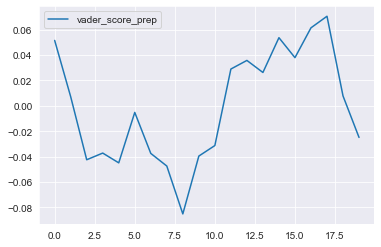

In [18]:
lagged_correlation_prep.plot(y='vader_score_prep', kind="line", use_index=True)
plt.show()

# Normalizing data

In [19]:
twitter_vaderAVG_priceAVG

,date,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
0,2018-01-01,0.078898,0.068968,13422.567010,NaN
1,2018-01-02,0.042676,0.039405,13877.579911,3.389910
2,2018-01-03,0.039440,0.027376,14962.379078,7.816919
3,2018-01-04,0.070949,0.056791,14816.625468,-0.974134
4,2018-01-05,0.071774,0.061243,15790.446145,6.572486
...,...,...,...,...,...
360,2018-12-27,0.057753,0.056008,3717.518933,-1.624099
361,2018-12-28,0.058766,0.052362,3701.742855,-0.424371
362,2018-12-29,0.043943,0.037652,3873.097678,4.629031
363,2018-12-30,0.055277,0.049953,3787.887224,-2.200059


In [20]:
vader_score_prep_backup = twitter_vaderAVG_priceAVG['vader_score_prep']
vader_score_backup = twitter_vaderAVG_priceAVG['vader_score']
fluctuation_backup = twitter_vaderAVG_priceAVG['fluctuation (%)']

In [21]:
twitter_vaderAVG_priceAVG.set_index('date', inplace=True)

In [22]:
x = twitter_vaderAVG_priceAVG.values

In [23]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [24]:
twitter_vaderAVG_priceAVG.head()

,vader_score_prep,vader_score,Weighted_Price,fluctuation (%)
date,,,,
2018-01-01,0.078898,0.068968,13422.567010,NaN
2018-01-02,0.042676,0.039405,13877.579911,3.389910
2018-01-03,0.039440,0.027376,14962.379078,7.816919
2018-01-04,0.070949,0.056791,14816.625468,-0.974134
2018-01-05,0.071774,0.061243,15790.446145,6.572486


In [25]:
twitter_vaderAVG_priceAVG_norm = pd.DataFrame(x_scaled, index=twitter_vaderAVG_priceAVG.index,
                                              columns=[
                                                  'vader_score_prep_norm',
                                                  'vader_score_norm',
                                                  'Weighted_Price_norm',
                                                  'fluctuation (%)_norm'
                                              ])
twitter_vaderAVG_priceAVG_norm

,vader_score_prep_norm,vader_score_norm,Weighted_Price_norm,fluctuation (%)_norm
date,,,,
2018-01-01,0.363177,0.338933,0.759554,NaN
2018-01-02,0.145401,0.155125,0.793293,0.565712
2018-01-03,0.125947,0.080330,0.873731,0.719559
2018-01-04,0.315386,0.263220,0.862923,0.414054
2018-01-05,0.320344,0.290904,0.935132,0.676312
...,...,...,...,...
2018-12-27,0.236048,0.258356,0.039927,0.391466
2018-12-28,0.242139,0.235682,0.038757,0.433159
2018-12-29,0.153015,0.144224,0.051463,0.608774


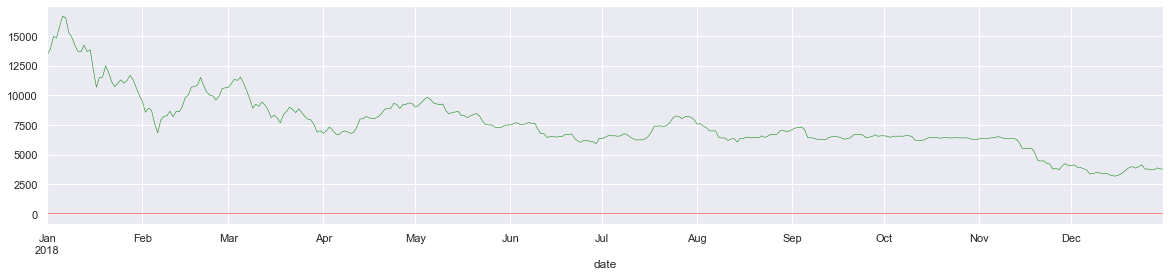

In [26]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG['Weighted_Price'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG['vader_score'].plot(linewidth=0.5, color='red');

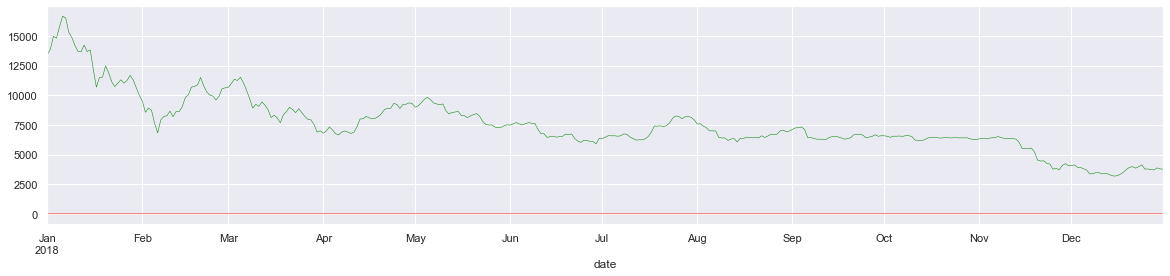

In [27]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG['Weighted_Price'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG['vader_score_prep'].plot(linewidth=0.5, color='red');

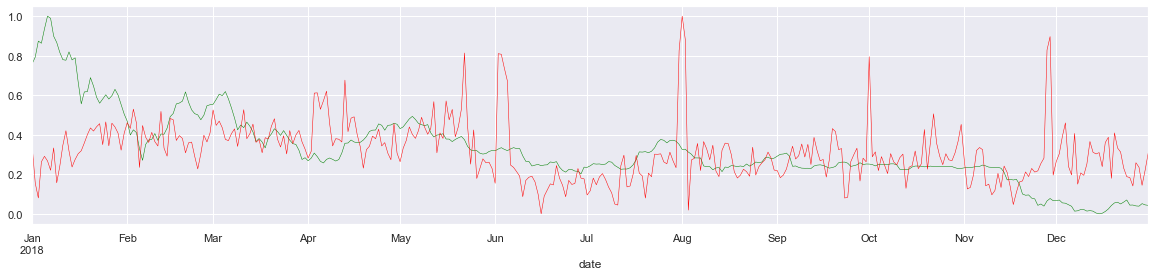

In [28]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG_norm['vader_score_norm'].plot(linewidth=0.5, color='red');

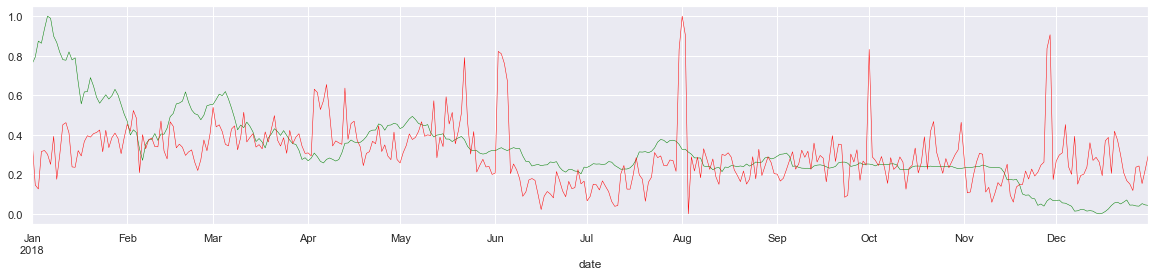

In [29]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm'].plot(linewidth=0.5, color='green');
twitter_vaderAVG_priceAVG_norm['vader_score_prep_norm'].plot(linewidth=0.5, color='red');

# Linear Regression

In [13]:
# X = reddit_corpus_norm_avg[['posts_body_vader_score_norm', 'world_len_body_norm']]
X = twitter_vaderAVG_priceAVG_norm[['vader_score_prep_norm']]
y = twitter_vaderAVG_priceAVG_norm[['Weighted_Price_norm']]
# Ordinary least squares Linear Regression.

#X = X.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.058692358404710765

In [14]:
# X = reddit_corpus_norm_avg[['posts_body_vader_score_norm', 'world_len_body_norm']]
X = twitter_vaderAVG_priceAVG_norm[['vader_score_norm']]
y = twitter_vaderAVG_priceAVG_norm[['Weighted_Price_norm']]
# Ordinary least squares Linear Regression.

#X = X.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.04615861549712619

In [15]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG_norm['vader_score_prep_norm']:
    if 1 > score > 0.05:
        vader_class_prep.append('positive')
    elif -0.05 > score > -1:
        vader_class_prep.append('negative')
    else:
        vader_class_prep.append('neutral')

# vader_class_prep

In [16]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'] = vader_class_prep

In [17]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'].value_counts()

positive    360
neutral       5
Name: vader_class_prep, dtype: int64

In [18]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG['vader_score']:
    if 1 > score > 0.05:
        vader_class_prep.append('positive')
    elif -0.05 > score > -1:
        vader_class_prep.append('negative')
    else:
        vader_class_prep.append('neutral')

# vader_class_prep

In [19]:
twitter_vaderAVG_priceAVG['vader_class'] = vader_class_prep

In [20]:
twitter_vaderAVG_priceAVG['vader_class'].value_counts()

positive    269
neutral      96
Name: vader_class, dtype: int64

In [22]:
vader_class_prep = []
for score in twitter_vaderAVG_priceAVG['vader_score_prep']:
    if 1 > score > 0.05:
        vader_class_prep.append('positive')
    elif -0.05 > score > -1:
        vader_class_prep.append('negative')
    else:
        vader_class_prep.append('neutral')

# vader_class_prep

In [23]:
twitter_vaderAVG_priceAVG['vader_class_prep'] = vader_class_prep

In [24]:
twitter_vaderAVG_priceAVG['vader_class_prep'].value_counts()

positive    289
neutral      76
Name: vader_class_prep, dtype: int64

In [25]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'] = twitter_vaderAVG_priceAVG['vader_class']

In [26]:
twitter_vaderAVG_priceAVG_norm['vader_class_prep'].value_counts()

positive    269
neutral      96
Name: vader_class_prep, dtype: int64

# Logistic Regression

In [27]:
X = twitter_vaderAVG_priceAVG_norm[['Weighted_Price_norm']]
y = twitter_vaderAVG_priceAVG_norm['vader_class_prep']

In [28]:
clf = LogisticRegression().fit(X, y)

In [29]:
clf.score(X,y)

0.736986301369863

# Support vector classifier

In [5]:
X = twitter_vaderAVG_priceAVG_norm[['Weighted_Price_norm']]
y = twitter_vaderAVG_priceAVG_norm['vader_class_prep']

In [31]:

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X,y)
#SVC(decision_function_shape='ovo')
clf.score(X,y)



0.736986301369863

# SPREG OLS

In [32]:
X.dtypes

Weighted_Price_norm    float64
dtype: object

In [33]:
X_spreg = X.to_numpy(dtype=float)
y_spreg = y.progress_apply(lambda x: 1 if x == 'positive' else 0).to_numpy(dtype=int)

100%|██████████| 365/365 [00:00<?, ?it/s]


In [34]:
spregOLS = spreg.OLS(y_spreg, X_spreg, nonspat_diag=True, name_y="vader_class_prep", name_x=['Weighted_Price_norm'])
print(spregOLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :vader_class_prep                Number of Observations:         365
Mean dependent var  :      0.7370                Number of Variables   :           2
S.D. dependent var  :      0.4409                Degrees of Freedom    :         363
R-squared           :      0.0687
Adjusted R-squared  :      0.0661
Sum squared residual:      65.890                F-statistic           :     26.7808
Sigma-square        :       0.182                Prob(F-statistic)     :    3.78e-07
S.E. of regression  :       0.426                Log likelihood        :    -205.488
Sigma-square ML     :       0.181                Akaike info criterion :     414.975
S.E of regression ML:      0.4249                Schwarz criterion     :     422.775

-------------------------------------------------------------------------

### With train test split for classification report

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [42]:
twitter_vaderAVG_priceAVG_norm.isna().any()

Unnamed: 0               False
date                     False
vader_score_prep_norm    False
vader_score_norm         False
Weighted_Price_norm      False
fluctuation (%)_norm     False
vader_class_prep         False
dtype: bool

In [43]:
twitter_vaderAVG_priceAVG_norm.fillna(0, inplace=True)

In [56]:
# X = twitter_vaderAVG_priceAVG_norm['Weighted_Price_norm'].to_list()
X = twitter_vaderAVG_priceAVG_norm['fluctuation (%)_norm'].to_list()
y = twitter_vaderAVG_priceAVG_norm['vader_class_prep'].to_list()
# y = twitter_vaderAVG_priceAVG_norm['vader_class_prep']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None, stratify=y)

In [58]:
X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))

#### Logistic Regression

In [59]:
logisticRegression = LogisticRegression().fit(X_train, y_train)
logisticRegression.score(X_test, y_test)

0.7363636363636363

In [60]:
from collections import Counter

In [61]:
y_pred = logisticRegression.predict(X_test)

In [62]:
Counter(y_test)

Counter({'neutral': 29, 'positive': 81})

In [63]:
Counter(y_pred)

Counter({'positive': 110})

In [64]:
target_names_logisticReg = ['pozitive', 'neutral']
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        29
    positive       0.74      1.00      0.85        81

    accuracy                           0.74       110
   macro avg       0.37      0.50      0.42       110
weighted avg       0.54      0.74      0.62       110



#### SVC

In [47]:
svc = svm.SVC(decision_function_shape='ovo')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7454545454545455

In [48]:
from collections import Counter

In [49]:
y_pred = svc.predict(X_test)

In [50]:
Counter(y_test)

Counter({'positive': 82, 'neutral': 28})

In [51]:
Counter(y_pred)

Counter({'positive': 110})

In [52]:
target_names_svc = ['pozitive', 'neutral']
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        28
    positive       0.75      1.00      0.85        82

    accuracy                           0.75       110
   macro avg       0.37      0.50      0.43       110
weighted avg       0.56      0.75      0.64       110



In [53]:
twitter_vaderAVG_priceAVG_norm.to_csv('data/twitter_vaderAVG_priceAVG_norm.csv')
twitter_vaderAVG_priceAVG_norm.to_csv('data/final.csv')

In [2]:
twitter_vaderAVG_priceAVG_norm = pd.read_csv('data/twitter_vaderAVG_priceAVG_norm.csv')
twitter_vaderAVG_priceAVG = pd.read_csv('data/twitter_vaderAVG_priceAVG.csv')